In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, glob, inspect, sys
import matplotlib.pyplot as plt
%matplotlib inline

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/Survival_df.csv'),
                  index_col=0)
df

,Observed,F_Time,NDE_cycle,diff_two_peaks_ratio,amp_ratio,pos_ratio,energy_ratio,NLE_ratio_51_17,NLE_ratio_85_17,NLE_ratio_51_119,NLO_avg,Avg_RP,ACEE_30_Avg_58,ACEE_500_Avg_58,ACPD_Avg_58
ID,,,,,,,,,,,,,,,
41C,True,2154137.0,0,2.104871,1.185236,1.002988,1.559453,0.893268,1.107898,1.931463,5.576476,190.979294,-0.137640,-2.866030,4.804749
44C,True,1318034.0,0,2.280959,1.365329,0.998446,1.504218,0.888503,1.140535,1.862064,4.619563,187.204261,-0.596385,-2.788500,3.370729
45C,False,3245267.0,0,1.245687,0.809970,0.989351,1.282046,0.896534,1.137561,1.824140,3.458337,189.010633,-0.645710,-3.202220,4.186639
24C,False,1330000.0,300000,0.588694,1.061223,1.005517,1.030618,0.844482,1.030615,1.927292,5.064456,174.454983,-0.816755,-1.836935,4.259982
34C,False,700000.0,300000,0.589633,0.999639,1.002006,0.821495,0.780283,0.999564,1.719235,4.849455,170.036299,-1.014340,-1.521755,3.579960
19C,True,464392.0,450000,0.763296,1.128928,1.002407,1.126849,0.978877,1.235508,1.846582,3.798736,171.925123,-1.065155,-1.570740,3.226957
30C,True,1103303.0,450000,0.388101,1.069920,1.004996,0.932989,0.924855,1.195796,1.793760,3.513676,174.421961,-0.968130,-1.248220,3.305279
32C,True,306142.0,450000,0.610771,1.137713,0.994283,0.844962,0.844824,1.091099,1.839907,4.296261,169.717689,-0.617190,-1.312415,2.907922
46C,True,447380.0,450000,0.742724,0.917101,0.977985,0.946441,0.892038,1.188698,1.748973,6.444959,172.526654,-1.064230,-1.176100,3.526969


In [3]:
df_y=df.iloc[:, :2]
df_x=df.iloc[:, 2:]
df_y=df_y.to_records(index=False)


In [4]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(12, 8))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "  ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

# Choosing penalty strength α by running a GridSearch

For prediction, we need to pick one particular α, and the subset of features it implies. Here, we are going to use cross-validation to determine which subset and α generalizes best.

Before we can use GridSearchCV, we need to determine the set of α which we want to evaluate. To do this, we fit a penalized Cox model to the whole data and retrieve the estimated set of alphas. Since, we are only interested in alphas and not the coefficients, we can use only a few iterations for improved speed. Note that we are using MinMaxScaler() to account for scale differences among features and allow direct comparison of coefficients.

In [5]:
coxnet_pipe = make_pipeline(
    MinMaxScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=10000) 
)
#ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100) so increased it to 10000

coxnet_pipe.fit(df_x, df_y)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=10000))])

In [6]:
alphas = 10. ** np.linspace(-4, 4, 50) # me make a list of alphas

cv = KFold(n_splits=3, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(MinMaxScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(df_x, df_y)

cv_results = pd.DataFrame(gcv.cv_results_)

mean test score: 0.6891534391534391
alpha for best and generalized fit: 0.08685113737513521


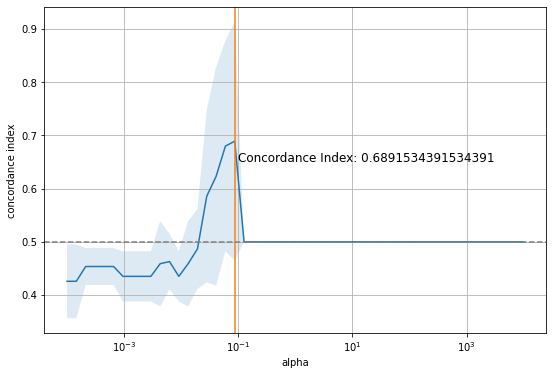

In [7]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")


ax.annotate('Concordance Index: 0.6891534391534391 ', xy=(0.05,0.6), xytext=(0.1, 0.65), fontsize=12)
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

print("mean test score:", cv_results.mean_test_score.max())
print("alpha for best and generalized fit:", gcv.best_params_["coxnetsurvivalanalysis__alphas"][0])

Number of non-zero coefficients: 1


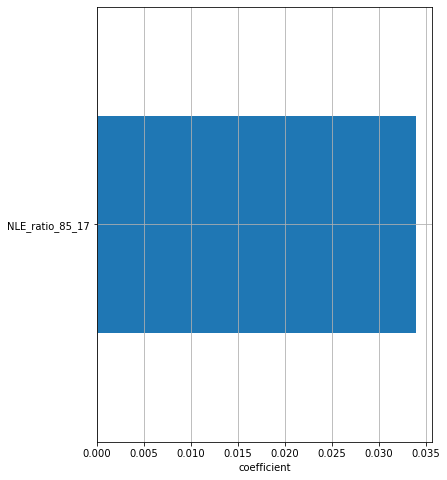

In [8]:
# we plot the non-zero coefficient at the alpha determined
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=df_x.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

Not very useful since it only gives 1 feature with a non-zero coefficient

# Elastic Net
The LASSO is a great tool to select a subset of discriminative features, but it has two main drawbacks. First, it cannot select more features than number of samples in the training data, which is problematic when dealing with very high-dimensional data. Second, if data contains a group of features that are highly correlated, the LASSO penalty is going to randomly choose one feature from this group. The Elastic Net penalty overcomes these problems by using a weighted combination of the ℓ1 and ℓ2 penalty by solving:

            argmaxβlogPL(β)−α(r∑j=1p|βj|+1−r2∑j=1pβ2j),
where r∈[0;1[ is the relative weight of the ℓ1 and ℓ2 penalty. The Elastic Net penalty combines the subset selection property of the LASSO with the regularization strength of the Ridge penalty. This leads to better stability compared to the LASSO penalized model. For a group of highly correlated features, the latter would choose one feature randomly, whereas the Elastic Net penalized model would tend to select all. Usually, it is sufficient to give the ℓ2 penalty only a small weight to improve stability of the LASSO, e.g. by setting r=0.9.

As for the LASSO, the weight α implicitly determines the size of the selected subset, and usually has to be estimated in a data-driven manner

In [9]:
# Drop NDE_cycle feature to observe more feature coefficients as it has a significant effect on the elastic net plot
df_x.drop(['NDE_cycle'], axis=1, inplace=True)

In [10]:
#we plot the elastic net with the same penality parameter of l1_ratio=0.9 to plot coefficient plot

cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(df_x, df_y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

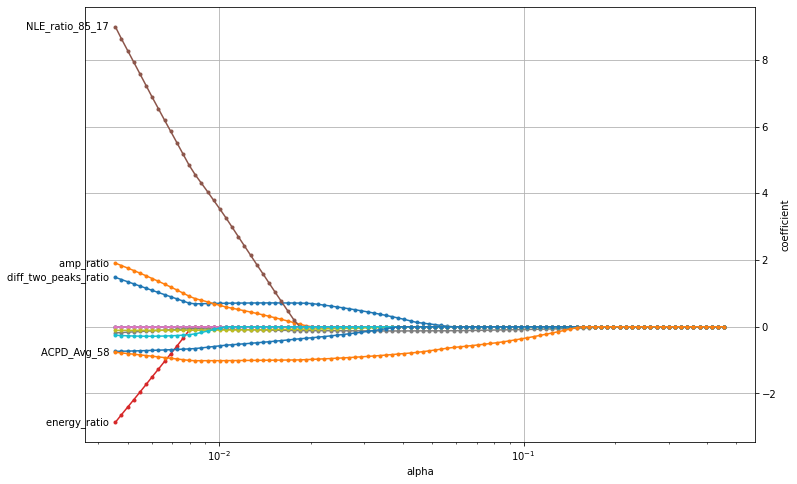

In [11]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_,
    index=df_x.columns,
    columns=np.round(cox_elastic_net.alphas_, 5)
)
plot_coefficients(coefficients_elastic_net, n_highlight=5)

In this plot we can see that the alpha value determined above is approx. 0.08 which we can see to have only 1 non-zero from the previous plot but for ther elasticnet plot alpha value below that will give more features to include. The reason for the previous plot above is that corcandence index is not recommend to use when there is a high level of censoring and ipcw index should be used. 